In [1]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import polars as pl
from sklearn.preprocessing import StandardScaler

## Data Loading

In [2]:
# load data from s3 storage
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
data = reader.read_parquet("preprocessed.parquet/data_clean_symb_1.parquet")

# Split and standardization

In [3]:
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X = data.select(features)
y = data.select(target) 

n = X.height
n_train = int(0.8 * n)
X_train_raw = X.slice(0, n_train)
y_train_raw = y.slice(0, n_train)
X_val_raw = X.slice(n_train)
y_val_raw = y.slice(n_train)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = pl.from_numpy(
    scaler_x.fit_transform(X_train_raw.to_numpy()), 
    schema=X_train_raw.schema
)
X_val = pl.from_numpy(
    scaler_x.transform(X_val_raw.to_numpy()), 
    schema=X_val_raw.schema
)

y_train = pl.from_numpy(
    scaler_y.fit_transform(y_train_raw.to_numpy()), 
    schema=y_train_raw.schema
)
y_val = pl.from_numpy(
    scaler_y.transform(y_val_raw.to_numpy()), 
    schema=y_val_raw.schema
)

# Train

  5%|▌         | 1/20 [03:23<1:04:29, 203.65s/it]

Epoch 001 | R² Train: 0.7936 | R² Val: 0.8275


 10%|█         | 2/20 [06:47<1:01:04, 203.57s/it]

Epoch 002 | R² Train: 0.8400 | R² Val: 0.8505


 15%|█▌        | 3/20 [10:12<57:53, 204.35s/it]  

Epoch 003 | R² Train: 0.8486 | R² Val: 0.8585


 20%|██        | 4/20 [13:40<54:50, 205.64s/it]

Epoch 004 | R² Train: 0.8540 | R² Val: 0.8571


 25%|██▌       | 5/20 [17:02<51:07, 204.50s/it]

Epoch 005 | R² Train: 0.8579 | R² Val: 0.8499


 30%|███       | 6/20 [20:25<47:36, 204.04s/it]

Epoch 006 | R² Train: 0.8607 | R² Val: 0.8635


 35%|███▌      | 7/20 [23:48<44:05, 203.49s/it]

Epoch 007 | R² Train: 0.8636 | R² Val: 0.8597


 40%|████      | 8/20 [27:10<40:37, 203.09s/it]

Epoch 008 | R² Train: 0.8656 | R² Val: 0.8684


 45%|████▌     | 9/20 [30:34<37:16, 203.34s/it]

Epoch 009 | R² Train: 0.8662 | R² Val: 0.8516


 50%|█████     | 10/20 [33:57<33:53, 203.37s/it]

Epoch 010 | R² Train: 0.8662 | R² Val: 0.8677


 55%|█████▌    | 11/20 [37:19<30:26, 202.98s/it]

Epoch 011 | R² Train: 0.8689 | R² Val: 0.8666


 60%|██████    | 12/20 [40:42<27:03, 202.90s/it]

Epoch 012 | R² Train: 0.8683 | R² Val: 0.8704


 65%|██████▌   | 13/20 [44:04<23:39, 202.80s/it]

Epoch 013 | R² Train: 0.8695 | R² Val: 0.8651


 70%|███████   | 14/20 [47:27<20:16, 202.80s/it]

Epoch 014 | R² Train: 0.8692 | R² Val: 0.8723


 75%|███████▌  | 15/20 [50:49<16:51, 202.33s/it]

Epoch 015 | R² Train: 0.8702 | R² Val: 0.8675


 80%|████████  | 16/20 [54:12<13:30, 202.55s/it]

Epoch 016 | R² Train: 0.8696 | R² Val: 0.8695


 85%|████████▌ | 17/20 [57:33<10:06, 202.16s/it]

Epoch 017 | R² Train: 0.8616 | R² Val: 0.8647


 90%|█████████ | 18/20 [1:00:55<06:44, 202.22s/it]

Epoch 018 | R² Train: 0.8677 | R² Val: 0.8756


 95%|█████████▌| 19/20 [1:04:18<03:22, 202.31s/it]

Epoch 019 | R² Train: 0.8711 | R² Val: 0.8735


100%|██████████| 20/20 [1:07:40<00:00, 203.01s/it]

Epoch 020 | R² Train: 0.8714 | R² Val: 0.8703


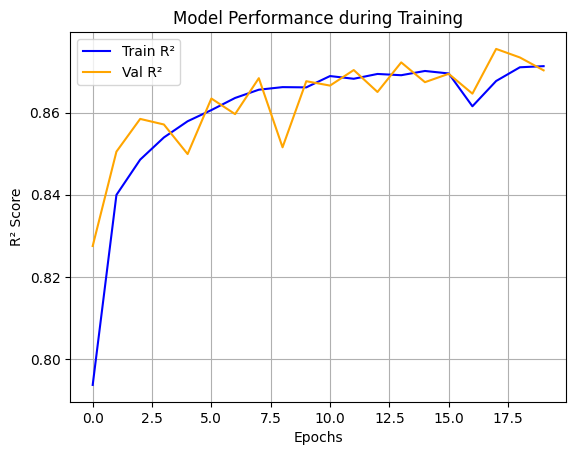

In [4]:
from models.transformers import TimeSeriesTransformer
from models.transformers_utils import train_model

n_features = X_train.shape[1]
lr = 0.5e-2
criterion = nn.MSELoss()
n_epochs = 20
batch_size = 2048
device = "cuda"
seq_len = 128
d_model = 16
num_heads = 4
num_layers = 3
d_ff = 16

model = TimeSeriesTransformer(
    n_features=n_features,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff
)

optimizer = optim.Adam(model.parameters(), lr=lr)

r2_train_hist, r2_val_hist = train_model(
    model, optimizer, criterion, 
    X_train, y_train, X_val, y_val,
    epochs=n_epochs, batch_size=batch_size, seq_len=seq_len, device=device, plot=True
)

In [11]:
import pandas as pd
scores = pd.DataFrame({
    "train":r2_train_hist,
    "val":r2_val_hist
})
scores.to_parquet("0_baseline_tf_scores.parquet")